# Neural Networks for Data Science Applications
## Mid-term Homework: Implementing a custom activation function

**Name**: *Alessandro Taglieri*

**Matricola**: *1890945*

Send the completed notebook before 03/12/2020 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_1_\<id\>".

In [1]:
import tensorflow as tf

### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Exercise 1: implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

**Exercise 1**: *After carefully reading the guides*, complete the following implementation of the PELU activation function.

In [27]:
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras import backend as K

def greater_than_zero(value):
	eps = 1e-9
	return eps + K.pow(value, 2)
 
class PELU(tf.keras.layers.Layer):

    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    def build(self, input_shape=_):

        param_init = tf.random_uniform_initializer(minval=0.1, maxval=1)
        self.params = self.add_weight(
            shape = (self.units, 2), 
            initializer = param_init,
            constraint = NonNeg(), 
            dtype='float32', 
            trainable = True
            
        )
        

    def call(self, inputs):
        alpha, beta = self.params[:,0], self.params[:,1]
        first = greater_than_zero(alpha)/greater_than_zero(beta)*inputs*tf.cast(inputs>=0, dtype='float32')
        two = greater_than_zero(alpha)*(K.exp(inputs/greater_than_zero(beta)*tf.cast(inputs<0, dtype='float32'))-1)
        
        return first + two
        
      

**Hints for a correct implementation**:

1. The layer (probably) requires two sets of trainable variables, whose shape depends on the number of units.
2. From the definition of the PELU, $\alpha, \beta$ are required to be positive in order to ensure differentiability. The simplest way to handle this is to use a [constraint callable](https://www.tensorflow.org/api_docs/python/tf/keras/constraints) when creating the weight (see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) for `add_weight`).

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

In [38]:
pelu = PELU(units=1)

**Exercise 2.1**: plot the function using the skeleton code below.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



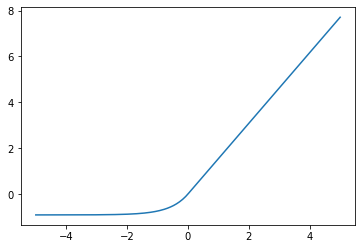

In [39]:
import matplotlib.pyplot as plt
x_range = tf.linspace(-5, 5, 200) # An equispaced grid of 200 points in [-5, +5]
y = pelu(x_range.numpy())

plt.plot(x_range.numpy(), y.numpy())

The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

**Exercise 2.2**: using a `tf.GradientTape` object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

**Hints for a correct implementation**:

1. `tf.GradientTape` allows to compute the derivative *at a single point x*. If you prefer to avoid a loop over all possible points, consider using the `jacobian` function to obtain them in a single pass ([Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff)).
2. Given two tensors x and y, a simple way to compute elementwise similarity up to a certain precision (e.g., $10^{-4}$), is given by `tf.reduce_all(tf.abs(x - y) < 1e-4)`.



In [5]:
# compute derivative of a pelu function with alpha given by the formula[2] and respect to beta
def gradient(x, params):
    alpha, beta = params[:,0], params[:,1]
    
    alpha_gr = tf.where(x>=0, x/beta, tf.exp(x/beta)-1)
    beta_gr = tf.where(x>=0, -alpha/beta**2*x, -alpha*x/beta**2*tf.exp(x/beta))
    
    return tf.stack([alpha_gr, beta_gr], axis=1)

In [6]:
#compute gradient and we'll have in output two tensor: gradient and tf_gradient that we use to computee their elemntwise similiarity

with tf.GradientTape() as tape:
    #tape.watch(x_range)
    pelu_res = pelu(x_range)


grad = tape.jacobian(pelu_res, pelu.params)

tf_gradient = tf.reshape(grad, shape=(-1, 2))
gradient = gradient(tf.cast(x_range, tf.float32), pelu.params)

In [7]:
#compute elementwise similarity up to a certain precision (e.g.,  (10)^−4 )
tf.reduce_all(tf.abs(tf_gradient - gradient) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

**Exercise 2.3 (optional)**: try the same for the $\beta$ parameter (you can check the analytical formula for the gradient in the original paper [2]). **Careful**: the equation in the original paper has a missing $h$ (thanks to Davide Aureli and Federico Siciliano for spotting this). See [the correct derivation](https://www.wolframalpha.com/input/?i=d%28a*%28exp%28h%2Fb%29-1%29%29%2Fdb) on Wolfram Alpha.

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

In [8]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

#sequential model with Pelu
model = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(50),
      PELU(50),
      tf.keras.layers.Dense(10, activation='softmax')
])

**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

In [9]:
#we use the mnist dataset to fit and test our moddel. You can find this ddataset from the sample_data
import pandas as pd
train = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
X_tr = train.iloc[:, 1:].values.astype('float32')
y_tr = train.iloc[:, 0].values.reshape(-1,1).astype('float32')
test = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)
X_tst = test.iloc[:, 1:].values.astype('float32')
y_tst = test.iloc[:, 0].values.reshape(-1,1).astype('float32')


In [10]:
#get train_dataset and test_dataset to use in the fit/test
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
train_dataset = train_dataset.shuffle(1000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_tst, y_tst)).batch(32)

In [11]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
#define measures that we use in the compile function
sgd = optimizers.SGD(learning_rate=1e-3)
cross_entropy = losses.SparseCategoricalCrossentropy()



In [12]:
from time import time
#calculate time and other paramteter  to define performances of the model. This is needed to compare model with pelu with model with relu
model.compile(optimizer=sgd,
              loss=cross_entropy,
              metrics=['accuracy'])
start_time = time()
history_fit_pelu = model.fit(train_dataset, epochs=10)
pelu_fit_time = time() - start_time

start_time = time()
history_eval_pelu=model.evaluate(test_dataset)
pelu_eval_time = time() - start_time

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 7.8304 - accuracy: 0.4430
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.7654 - accuracy: 0.7753
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5525 - accuracy: 0.8371
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4653 - accuracy: 0.8644
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4137 - accuracy: 0.8817
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3802 - accuracy: 0.8931
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3554 - accuracy: 0.8992
Epoch 8/10
625/625 [==============================] - 2s 2ms/step - loss: 0.3365 - accuracy: 0.9048
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3189 - accuracy: 0.9093
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3533 - accuracy: 0.9030

In [13]:
#summary of the model with pelu
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
pelu_1 (PELU)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 39,860
Trainable params: 39,860
Non-trainable params: 0
_________________________________________________________________


**Exercise 3.1**: Additionally, compare with a standard ReLU activation.

In [14]:
#define model with Relu
model_withRelu = Sequential(layers=[
                           
                           tf.keras.layers.Dense(50, activation='relu'),
                           tf.keras.layers.Dense(11, activation='softmax')
])
#calculate time and other measures to get performances of this model during training and test
model_withRelu.compile(optimizer=sgd,
              loss=cross_entropy,
              metrics=['accuracy'])
start_time = time()
history_fit_relu = model_withRelu.fit(train_dataset, epochs=10)
relu_fit_time = time() - start_time

start_time = time()
history_eval_relu=model_withRelu.evaluate(test_dataset)
relu_eval_time = time() - start_time



Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 2.8565 - accuracy: 0.4701
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 1.1999 - accuracy: 0.6478
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.9925 - accuracy: 0.7295
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.8702 - accuracy: 0.7652
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.7554 - accuracy: 0.8026
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6861 - accuracy: 0.8054
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6222 - accuracy: 0.8142
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5542 - accuracy: 0.8439
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4875 - accuracy: 0.8594
Epoch 10/10
313/313 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.8574

In [15]:
#summary of the model with Relu
model_withRelu.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                561       
Total params: 39,811
Trainable params: 39,811
Non-trainable params: 0
_________________________________________________________________


In [16]:
#simple function that calculate the average from the list
def average(lst): 
    return sum(lst) / len(lst) 

Compare two models

In [17]:
#we put all measures that we obtained for both model in a dataframe. §in this way we can see the differences.
data = [{'fit time': pelu_fit_time, 'eval time': pelu_eval_time, 'mean accuracy':average(history_fit_pelu.history['accuracy']),'mean loss':average(history_fit_pelu.history['loss']),'test_loss':history_eval_pelu[0],'test_acc':history_eval_pelu[1]},
        {'fit time': relu_fit_time, 'eval time': relu_eval_time, 'mean accuracy':average(history_fit_relu.history['accuracy']),'mean loss':average(history_fit_relu.history['loss']),'test_loss':history_eval_relu[0],'test_acc':history_eval_relu[1]}
        
        ] 
performances = pd.DataFrame(data, index = ['Pelu','Relu']) 

In [18]:
performances

,fit time,eval time,mean accuracy,mean loss,test_loss,test_acc
Pelu,15.656992,0.776146,0.832125,1.172545,0.353307,0.9030
Relu,12.463586,0.606503,0.760770,0.946515,0.619113,0.8574


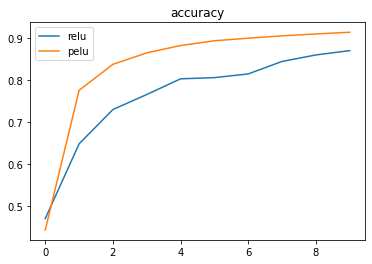

In [19]:
#plot acuracy during training
import matplotlib.pyplot as plt
plt.plot(history_fit_relu.history['accuracy'],label='relu')
plt.plot(history_fit_pelu.history['accuracy'],label='pelu')
plt.title('accuracy')
plt.legend()

**Considerations:**
From the results we can see that the training time in PELU is higher than the fit time in Relu, because the computation for the PELU is higher. Than we can notice that the accuracy on the test set is higher than the accuracy that we had during evaluation in Relu


TensorFlow has several options for saving or loading objects from the disk:

1. [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize/)

In many cases, custom classes require the implementation of a `get_config` / `from_config` functions to define the serialization behaviour.

**Exercise 4 (optional)**: implement the `get_config` method and test your implementation as below (taken from the guide on saving and loading models).

In [20]:

#model.save('pelu_model2')
#del PELU # This is needed to remove any reference to PELU from memory
#reloaded_model = tf.keras.models.load_model('pelu_model2')


In [21]:

#print("Original model:", model)
#print("Loaded model:", reloaded_model) # Observe that the object has been dynamically recreated in absence of the configuration options

Implementation af The PELU layer with get_config and from_config methods.


In [22]:

class PELU(tf.keras.layers.Layer):

    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    def build(self, input_shape=_):

        param_init = tf.random_uniform_initializer(minval=0.1, maxval=1)
        self.params = self.add_weight(
            shape = (self.units, 2), 
            initializer = param_init, 
            trainable = True, 
            constraint = NonNeg(), 
            dtype='float32'
        )

    def call(self, inputs):
        alpha, beta = self.params[:,0], self.params[:,1]
        pos = (greater_than_zero(alpha) / greater_than_zero(beta)) * tf.keras.activations.relu(inputs)
        neg = greater_than_zero(alpha) * (K.exp((-tf.keras.activations.relu(-inputs)) / greater_than_zero(beta)) - 1)

        return pos + neg

    def get_config(self):
        config = super(PELU, self).get_config()
      
        return {"units": self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [23]:
model = Sequential(layers=[
                           tf.keras.layers.Dense(50),
                           PELU(50),
                           tf.keras.layers.Dense(11, activation='softmax')
])

model.compile(optimizer=sgd,
              loss=cross_entropy,
              metrics=['accuracy'])
model.fit(train_dataset, epochs=10)
model.evaluate(test_dataset)

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 32996298.0000 - accuracy: 0.5658
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.7754 - accuracy: 0.7643
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5761 - accuracy: 0.8367
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4625 - accuracy: 0.8664
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3994 - accuracy: 0.8830
Epoch 6/10
625/625 [==============================] - 2s 2ms/step - loss: 0.3616 - accuracy: 0.8946
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3344 - accuracy: 0.9039
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3152 - accuracy: 0.9080
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3006 - accuracy: 0.9125
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3194 - accuracy:

[0.31942495703697205, 0.9079999923706055]

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                39250     
_________________________________________________________________
pelu_2 (PELU)                (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 11)                561       
Total params: 39,911
Trainable params: 39,911
Non-trainable params: 0
_________________________________________________________________


In [25]:
config = model.get_config()
new_model = tf.keras.Sequential.from_config(config, custom_objects={'PELU': PELU})

new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                39250     
_________________________________________________________________
pelu_3 (PELU)                (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 11)                561       
Total params: 39,911
Trainable params: 39,911
Non-trainable params: 0
_________________________________________________________________


### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.